In [1]:
import pandas as pd
import numpy as np
import datetime as dt


In [65]:
data = pd.read_csv('RFM.txt', sep='\t')



In [67]:
data['ParsedDate'] = data['Date'].apply(lambda x: dt.datetime.strptime(x,"%m/%d/%Y"))

In [47]:
NOW-dt.datetime.strptime(data['Date'][0], '%m/%d/%Y')

datetime.timedelta(546)

In [27]:
d.strftime('%Y-%m-%d')

'2014-07-17'

In [68]:
NOW = dt.datetime(2015,12,21)

In [69]:
rfmTable = data.groupby('account_id').agg({ 'ParsedDate': lambda x: (NOW - x.max()), # R
                                            'Order_Number': lambda x: len(x), # F
                                            'Value': lambda x: x.sum()}) # M


In [70]:
rfmTable.rename(columns={'ParsedDate': 'R', 'Order_Number': 'F', 'Value': 'M'}, inplace=True)

In [72]:
rfmTable.to_csv('rfm.csv',encoding='UTF-8')

In [84]:
Rquant = rfmTable['R'].quantile([0.0,0.25,0.50,0.75,1.0])
Fquant = rfmTable['F'].quantile([0.0,0.25,0.50,0.75,1.0])
Mquant = rfmTable['M'].quantile([0.0,0.25,0.50,0.75,1.0])


In [85]:
Rquant

0.00     1 days
0.25    87 days
0.50   111 days
0.75   174 days
1.00   522 days
dtype: timedelta64[ns]

In [86]:
rfmTable['Rsegment'] = rfmTable['R'].apply(lambda x: Rquant.searchsorted(x, side='right')[0])
rfmTable['Fsegment'] = rfmTable['F'].apply(lambda x: Fquant.searchsorted(x, side='right')[0])
rfmTable['Msegment'] = rfmTable['M'].apply(lambda x: Mquant.searchsorted(x, side='right')[0])


In [83]:
rfmTable.to_csv('rfmsegment1.csv')

In [122]:
from __future__ import division
from linear_algebra import squared_distance, vector_mean, distance
import math, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

class KMeans:
    """performs k-means clustering"""

    def __init__(self, k):
        self.k = k          # number of clusters
        self.means = None   # means of clusters
        
    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))
                   
    def train(self, inputs):
    
        self.means = random.sample(inputs, self.k)
        assignments = None
        
        while True:
            # Find new assignments
            new_assignments = map(self.classify, inputs)

            # If no assignments have changed, we're done.
            if assignments == new_assignments:                
                return

            # Otherwise keep the new assignments,
            assignments = new_assignments    

            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # avoid divide-by-zero if i_points is empty
                if i_points:                                
                    self.means[i] = vector_mean(i_points)    

def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = map(clusterer.classify, inputs)
    
    return sum(squared_distance(input,means[cluster])
               for input, cluster in zip(inputs, assignments))

def plot_squared_clustering_errors(plt,a):

    ks = range(1, a)
    errors = [squared_clustering_errors(inputs, k) for k in ks]

    plt.plot(ks, errors)
    plt.xticks(ks)
    plt.xlabel("k")
    plt.ylabel("total squared error")
    plt.show()

#
# using clustering to recolor an image
#

def recolor_image(input_file, k=5):

    img = mpimg.imread(path_to_png_file)
    pixels = [pixel for row in img for pixel in row]
    clusterer = KMeans(k)
    clusterer.train(pixels) # this might take a while    

    def recolor(pixel):
        cluster = clusterer.classify(pixel) # index of the closest cluster
        return clusterer.means[cluster]     # mean of the closest cluster

    new_img = [[recolor(pixel) for pixel in row]
               for row in img]

    plt.imshow(new_img)
    plt.axis('off')
    plt.show()

#
# hierarchical clustering
#

def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1

def get_children(cluster):
    """returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster"""
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]

def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster # is already a 1-tuple containing value
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]

def cluster_distance(cluster1, cluster2, distance_agg=min):
    """finds the aggregate distance between elements of cluster1
    and elements of cluster2"""
    return distance_agg([distance(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple

def bottom_up_cluster(inputs, distance_agg=min):
    # start with every input a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]
    
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                     key=lambda (x, y): cluster_distance(x, y, distance_agg))

        # remove them from the list of clusters
        import numpy
        clusters = [c for c in clusters if numpy.all (c != c1)and numpy.all (c != c2)]
        
        #numpy.all(0 <= x) and numpy.all(x < d):

        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]
    
    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list

In [89]:
import pandas as pd


In [90]:
df=pd.read_csv('rfmsegment.csv')

In [91]:
df.columns

Index([u'account_id', u'F', u'R', u'M', u'Rsegment', u'Fsegment', u'Msegment'], dtype='object')

In [95]:
df1=df.drop(['account_id','F','R','M'],axis=1)

In [98]:
inputs=df1.values
len(inputs)

12701

In [102]:
print "errors as a function of k"
for k in range(1, 20):
    print k, squared_clustering_errors(inputs, k)
print


errors as a function of k
1 40444.6503425
2 33386.6885757
3 16248.6509335
4 11075.0889703
5 10687.8962134
6 9089.68801271
7 8192.86750234
8 8501.36107702
9 7059.70292219
10 6342.47911554
11 5435.64492367
12 5318.03504643
13 5411.72513788
14 4967.04683556
15 4198.81665754
16 3826.77181767
17 4129.48419952
18 3199.05589524
19 3177.20022311



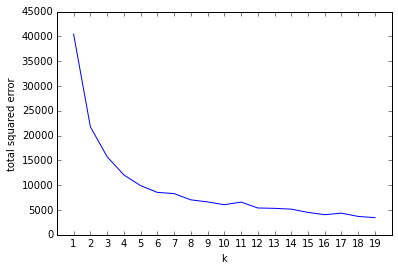

In [107]:
%matplotlib inline  
plot_squared_clustering_errors(plt,20)

In [108]:
random.seed(0) # so you get the same results as me
clusterer = KMeans(6)
clusterer.train(inputs)
print "6means:"
print clusterer.means
print


6means:
[[2.1370003416467371, 2.1288008199521693, 1.644345746498121], [2.8076213890596189, 3.1598033189920094, 2.6693300553165331], [4.5166438668490647, 2.8203374373005015, 2.5125398996808026], [4.5841514726507713, 3.8674614305750348, 3.7251051893408134], [2.6236453201970442, 3.2374384236453198, 3.9999999999999996], [3.7724005749880214, 2.113080977479636, 1.1528509822712028]]



In [119]:
import numpy 